# Predicting Flight Delays For Domestic Airlines

### Authors: Ethan Bleier, Elijah Kramer, Roberto Palacios

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) maintains performance records of domestic flights. These statistics include several interesting variables: dates, taxi times, delays, origins, destinations, departure, and arrival times. 

Using data analysis and various machine learning algorithms, this notebook plans to predict whether or not a flight will experience a delay. Specifically, we are interested in which predictors will play the biggest role in causing flight delays.

Our main dataset is taken from [Kaggle](https://www.kaggle.com/datasets/giovamata/airlinedelaycauses/data) and represents data from 2008. However, we expect to find that many of these same patterns found in this dataset to persist today.

In addition to this, we have [airport data]("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat") and [airline data]("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat") taken from [OpenFlights.org](https://openflights.org/) to help fill in gaps in data and previous knowledge.

### Python/environment setup

In [236]:
# Module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# scipy
from scipy.stats import zscore

In [237]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = 6, 4

### Reading in data

First, let's read in our main dataset. We can download this directly using the `kagglehub` module.

In [238]:
path = kagglehub.dataset_download("giovamata/airlinedelaycauses")
df = pd.read_csv(path + '/DelayedFlights.csv')

Next we need to read in our 2 supporting datasets, both provided by openflights ([https://openflights.org/](https://openflights.org/)) and hosted on GitHub.
Unfortunately, these aren't formatted as nicely as our main dataset - while they're still technically valid .csvs, pandas expects to find column names in row 0 and these don't contain any. So we pass `header=None` to ensure we don't lose row 0 or end up with unexpected column names.

In [239]:
port_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", header=None)
plane_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat", header=None)

### Data Preprocessing

Let's start with some initial cleanup for our main dataset. First, we have a number of columns that don't seem very useful to us: so we drop these. Also, we know we plan to rely heavily on our `DepDelay` and `ArrDelay` variables - so we also drop any rows that have these missing.

In [240]:
df = df.drop(columns=["Year", "Unnamed: 0", "FlightNum", "TailNum", "Cancelled"])
df = df.dropna(subset=['DepDelay', 'ArrDelay'])

Lastly, let's generate some helper columns for us to use later.

In [241]:
# log10 is undefined for <= 0 values, so we set those NaN
with np.errstate(divide='ignore'):
    df['ArrDelayLog'] = np.where(df["ArrDelay"] > 0, np.log10(np.abs(df["ArrDelay"])), np.nan)
    df['DepDelayLog'] = np.where(df["DepDelay"] > 0, np.log10(np.abs(df["DepDelay"])), np.nan)

# Is flight actively delayed (not early or on-time)?
df["IsDelayed"] = df["ArrDelay"] > 0

df.head(30)

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,...,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelayLog,DepDelayLog,IsDelayed
0,1,3,4,2003.0,1955,2211.0,2225,WN,128.0,150.0,...,N,0,NaN,NaN,NaN,NaN,NaN,NaN,0.903090,False
1,1,3,4,754.0,735,1002.0,1000,WN,128.0,145.0,...,N,0,NaN,NaN,NaN,NaN,NaN,0.301030,1.278754,True
2,1,3,4,628.0,620,804.0,750,WN,96.0,90.0,...,N,0,NaN,NaN,NaN,NaN,NaN,1.146128,0.903090,True
3,1,3,4,1829.0,1755,1959.0,1925,WN,90.0,90.0,...,N,0,2.0,0.0,0.0,0.0,32.0,1.531479,1.531479,True
4,1,3,4,1940.0,1915,2121.0,2110,WN,101.0,115.0,...,N,0,NaN,NaN,NaN,NaN,NaN,1.041393,1.397940,True
5,1,3,4,1937.0,1830,2037.0,1940,WN,240.0,250.0,...,N,0,10.0,0.0,0.0,0.0,47.0,1.755875,1.826075,True
6,1,3,4,706.0,700,916.0,915,WN,130.0,135.0,...,N,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.778151,True
7,1,3,4,1644.0,1510,1845.0,1725,WN,121.0,135.0,...,N,0,8.0,0.0,0.0,0.0,72.0,1.903090,1.973128,True
8,1,3,4,1029.0,1020,1021.0,1010,WN,52.0,50.0,...,N,0,NaN,NaN,NaN,NaN,NaN,1.041393,0.954243,True
9,1,3,4,1452.0,1425,1640.0,1625,WN,228.0,240.0,...,N,0,3.0,0.0,0.0,0.0,12.0,1.176091,1.431364,True


Back to our openflights data, we still don't have any column names yet. Let's set these ourselves so things are a bit easier to work with.

In [242]:
# Assign column names for airport df
port_df.columns = ["AirportId", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TZ", "Type", "Source"]
port_df = port_df.sort_index()

# Assign column names for plane df
plane_df.columns = ["AirlineId", "ID", "Name", "IATA", "ICAO", "Callsign", "Country", "Active"]
plane_df = plane_df.sort_index()

Now we should be able to do a bit more cleanup. For instance, we can simplify things by making sure we only care about US airports.

In [243]:
# Drop rows for non-US airports, and airports without IATA codes
port_df = port_df[port_df["Country"] == "United States"]
port_df = port_df[port_df["IATA"] != "\\N"]

# Drop rows for non-US airlines, and airlines without IATA codes
plane_df = plane_df[plane_df["Country"] == "United States"]
plane_df = plane_df.dropna(subset = ["IATA"])

Finally, let's drop any the columns we don't need

In [244]:
port_df = port_df.drop(columns=["Source", "ICAO"])
plane_df = plane_df.drop(columns=["Name", "ICAO"])

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1928371 entries, 0 to 1936757
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Month              int64  
 1   DayofMonth         int64  
 2   DayOfWeek          int64  
 3   DepTime            float64
 4   CRSDepTime         int64  
 5   ArrTime            float64
 6   CRSArrTime         int64  
 7   UniqueCarrier      object 
 8   ActualElapsedTime  float64
 9   CRSElapsedTime     float64
 10  AirTime            float64
 11  ArrDelay           float64
 12  DepDelay           float64
 13  Origin             object 
 14  Dest               object 
 15  Distance           int64  
 16  TaxiIn             float64
 17  TaxiOut            float64
 18  CancellationCode   object 
 19  Diverted           int64  
 20  CarrierDelay       float64
 21  WeatherDelay       float64
 22  NASDelay           float64
 23  SecurityDelay      float64
 24  LateAircraftDelay  float64
 25  ArrDelayLog        floa

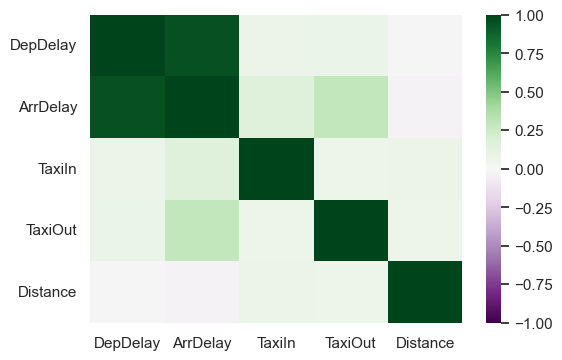

In [246]:
contin_vars = ["DepDelay","ArrDelay","TaxiIn", "TaxiOut", "Distance"]
sns.heatmap(df[contin_vars].corr(), cmap = "PRGn", vmin = -1, vmax = 1);

In [247]:
plane_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 10 to 6141
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   AirlineId  229 non-null    int64 
 1   ID         229 non-null    object
 2   IATA       229 non-null    object
 3   Callsign   169 non-null    object
 4   Country    229 non-null    object
 5   Active     229 non-null    object
dtypes: int64(1), object(5)
memory usage: 12.5+ KB


In [248]:
port_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1251 entries, 3212 to 7665
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AirportId  1251 non-null   int64  
 1   Name       1251 non-null   object 
 2   City       1251 non-null   object 
 3   Country    1251 non-null   object 
 4   IATA       1251 non-null   object 
 5   Latitude   1251 non-null   float64
 6   Longitude  1251 non-null   float64
 7   Altitude   1251 non-null   int64  
 8   Timezone   1251 non-null   object 
 9   DST        1251 non-null   object 
 10  TZ         1251 non-null   object 
 11  Type       1251 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 127.1+ KB


### Initial Data Exploration

While several factors may influence delays, we'd like to examine the constants in this situation rather than rely on chance incidents of weather or unexpected events. As such we'll first be looking at delays in relation to carriers.

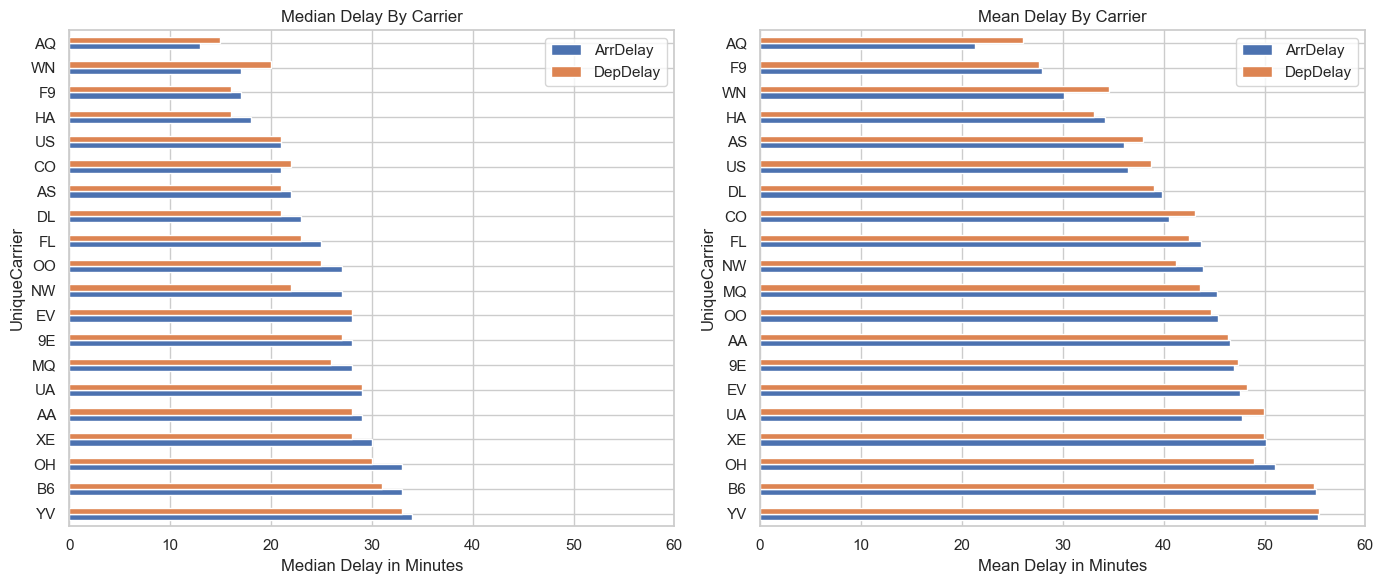

In [249]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))

median_carrier_delay = df.groupby("UniqueCarrier")[["ArrDelay", "DepDelay"]].median().sort_values(by ="ArrDelay", ascending = False)
mean_carrier_delay = df.groupby("UniqueCarrier")[["ArrDelay", "DepDelay"]].mean().sort_values(by ="ArrDelay", ascending = False)

median_carrier_delay.plot.barh(ax = ax1, title = "Median Delay By Carrier", xlabel = "Median Delay in Minutes");
mean_carrier_delay.plot.barh(ax = ax2, title = "Mean Delay By Carrier", xlabel = "Mean Delay in Minutes");

ax1.set_xlim(0,60)
ax2.set_xlim(0,60)

plt.tight_layout()
plt.show()

### Delays At Airports

This initial analysis suggests that delays are closely tied to carriers. Our dataset also contains a column that relates specifically to carrier delays, which could be used to elucidate some of these figures. However, over a third of these values are null, making further evaluation much more difficult. Instead, we'll explore the relationship between airports and delays.

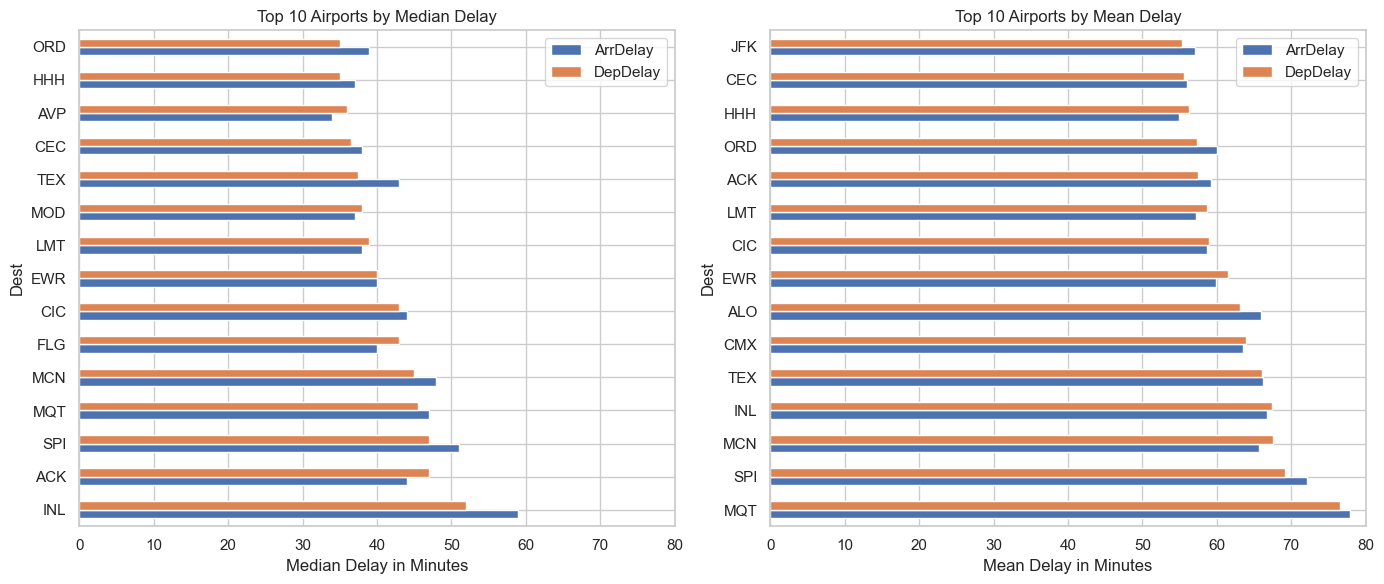

In [250]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))

dest_by_median_delay = df.groupby("Dest")[["ArrDelay","DepDelay"]].median().sort_values(by = "DepDelay", ascending = False).head(15)
dest_by_mean_delay = df.groupby("Dest")[["ArrDelay","DepDelay"]].mean().sort_values(by = "DepDelay", ascending = False).head(15)

dest_by_median_delay.plot.barh(ax = ax1, title = "Top 10 Airports by Median Delay", xlabel = "Median Delay in Minutes");
dest_by_mean_delay.plot.barh(ax = ax2, title = "Top 10 Airports by Mean Delay", xlabel = "Mean Delay in Minutes");

ax1.set_xlim(0, 80)
ax2.set_xlim(0, 80)

plt.tight_layout()
plt.show()

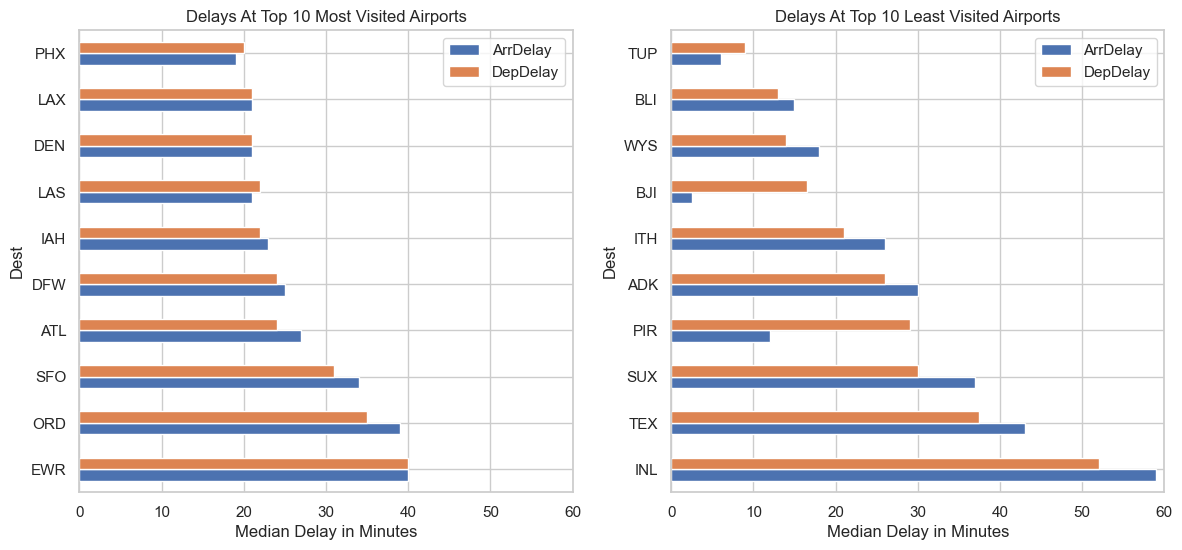

In [251]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))

top_ten_airports = df[df["Dest"].isin((df["Dest"].value_counts().head(10)).index)]
top_ten_airports.groupby("Dest")[["ArrDelay","DepDelay"]].median().sort_values(by = "DepDelay", ascending  = False).plot.barh(ax = ax1);

bottom_ten_airports = df[df["Dest"].isin((df["Dest"].value_counts().sort_values().head(10)).index)]
bottom_ten_airports.groupby("Dest")[["ArrDelay","DepDelay"]].median().sort_values(by = "DepDelay", ascending  = False).plot.barh(ax = ax2);

ax1.set_title("Delays At Top 10 Most Visited Airports")
ax1.set_xlabel("Median Delay in Minutes")

ax2.set_title("Delays At Top 10 Least Visited Airports")
ax2.set_xlabel("Median Delay in Minutes")

ax1.set_xlim(0, 60)
ax2.set_xlim(0, 60)

plt.show()

One might expect that busier airports are more likely to suffer flight delays but the data suggests otherwise. Smaller, regional airports appear to suffer equal or higher rates of delays when compared to high-volume airports. The main difference here lies in the consistency of the airports as the 10 most visited airports have similar rates of delay or are at least equal in their rate of arrival delay and departure delay. Low-traffic airports on the other hand vary from one another and even in their arrival and departure delays. 

From this information, we surmise that traffic is not a significant factor causing flight delays. As such we should look at other key variables such as the distance of each flight and the time of year the flight takes place.

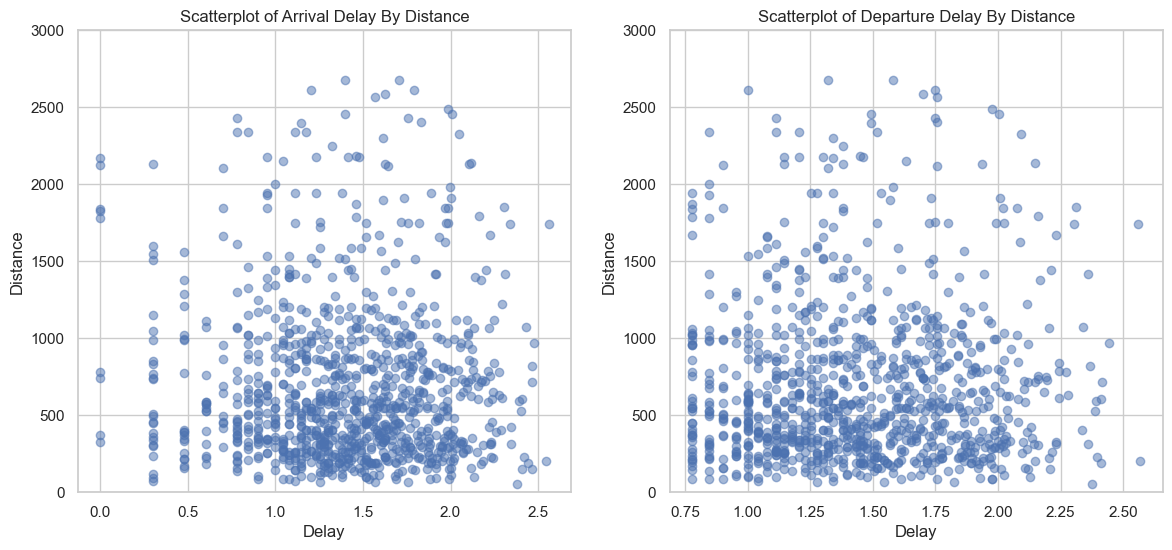

In [252]:
scatter_sample = df[df["CRSArrTime"] < df["ArrTime"]].sample(n = 1000, random_state = 42)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))

ax1.scatter(scatter_sample["ArrDelayLog"],scatter_sample["Distance"], alpha = 0.5)


ax1.set_ylim(0, 3000)
ax1.set_title("Scatterplot of Arrival Delay By Distance")
ax1.set_xlabel("Delay")
ax1.set_ylabel("Distance")

ax2.scatter(scatter_sample["DepDelayLog"],scatter_sample["Distance"], alpha = 0.5)

ax2.set_ylim(0, 3000)
ax2.set_title("Scatterplot of Departure Delay By Distance")
ax2.set_xlabel("Delay")
ax2.set_ylabel("Distance")

plt.show()

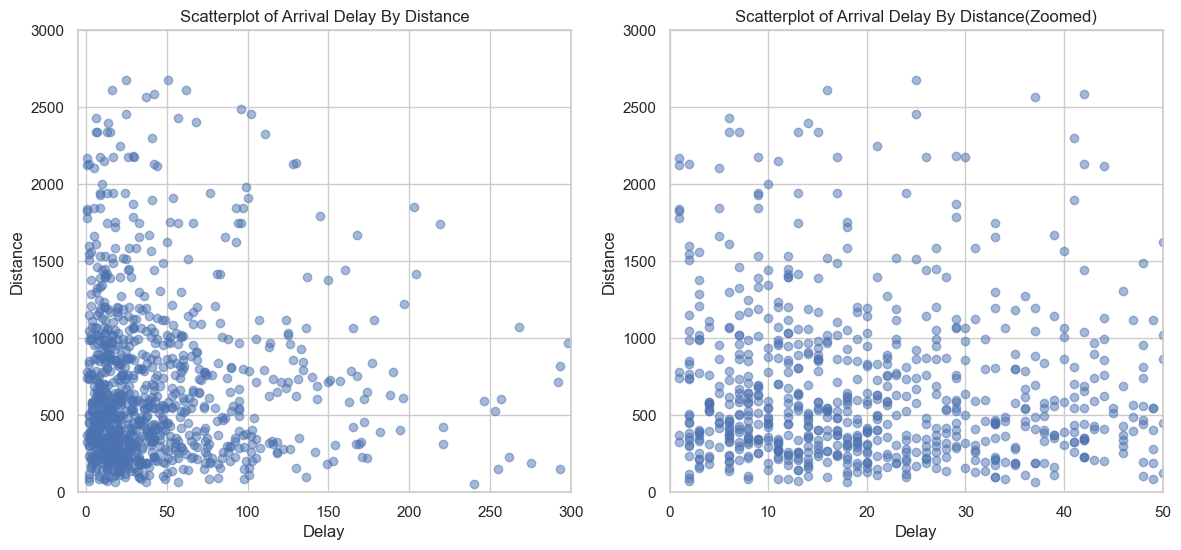

In [253]:
scatter_sample = df[df["CRSArrTime"] < df["ArrTime"]].sample(n = 1000, random_state = 42)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))
ax1.scatter(scatter_sample["ArrDelay"],scatter_sample["Distance"], alpha = 0.5)

ax1.set_xlim(-5, 300)
ax1.set_ylim(0, 3000)
ax1.set_title("Scatterplot of Arrival Delay By Distance")
ax1.set_xlabel("Delay")
ax1.set_ylabel("Distance")

ax2.scatter(scatter_sample["ArrDelay"],scatter_sample["Distance"], alpha = 0.5)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 3000)
ax2.set_title("Scatterplot of Arrival Delay By Distance(Zoomed)")
ax2.set_xlabel("Delay")
ax2.set_ylabel("Distance")

plt.show()

Unlike departure delays, some flights show negative values for arrival delays, meaning they arrived at their destinations earlier than expected. As such, we started by isolating flights that failed to arrive on time and then took a sample of those instances. Then, we plotted the arrival delay of these flights against their distance traveled.

The results show that delay times are evenly distributed regardless of the distance traveled, with outliers being the natural result of unforeseen incidents occurring occasionally.

Next, we'll assess how much of an impact the time of year has on flight delays

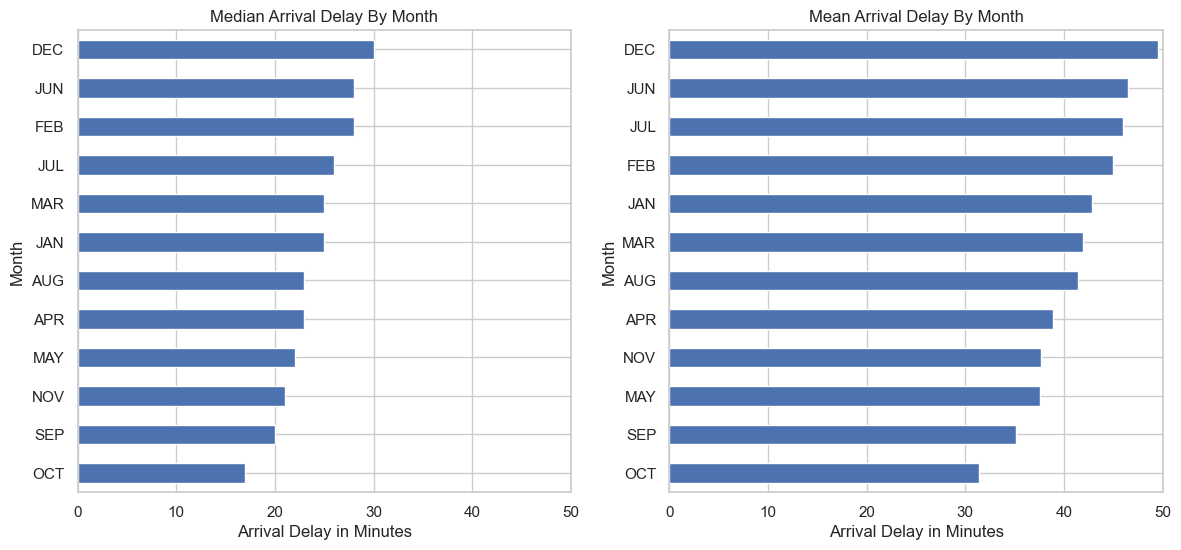

In [254]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

med_month_delay = df.groupby("Month")["ArrDelay"].median()
mean_month_delay = df.groupby("Month")["ArrDelay"].mean()

# applies months labels after grouping
med_month_delay.index = med_month_delay.index.map(lambda x:months[x-1])
mean_month_delay.index = mean_month_delay.index.map(lambda x:months[x-1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))

med_month_delay.sort_values().plot.barh(ax = ax1, title = "Median Arrival Delay By Month", xlabel = "Arrival Delay in Minutes")
mean_month_delay.sort_values().plot.barh(ax = ax2, title = "Mean Arrival Delay By Month", xlabel = "Arrival Delay in Minutes")

ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
# applies month labels after grouping. Can't be used with sorting or requires change of label order
# plt.yticks(ticks=range(12), labels = months)
plt.show()

When looking at the arrival delay by month, we notice a trend in the winter and summer months. These months often see much heavier flight traffic than normal due to people taking vacations or visiting family. As a result, arrival delays tend to increase in those months and stay relatively low for the rest of the year.

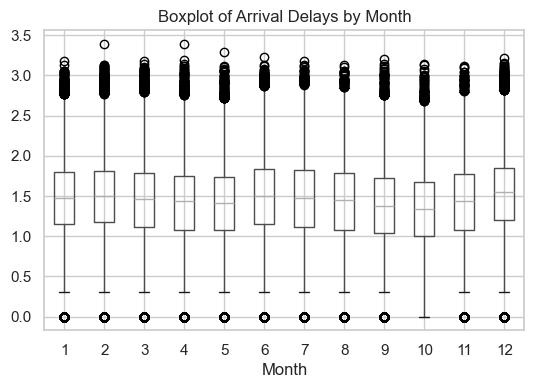

In [255]:
# this plot kinda cheeks but it shows all data points
df.boxplot(column = "ArrDelayLog" , by = "Month")
plt.suptitle("")
plt.title("Boxplot of Arrival Delays by Month")
plt.show()

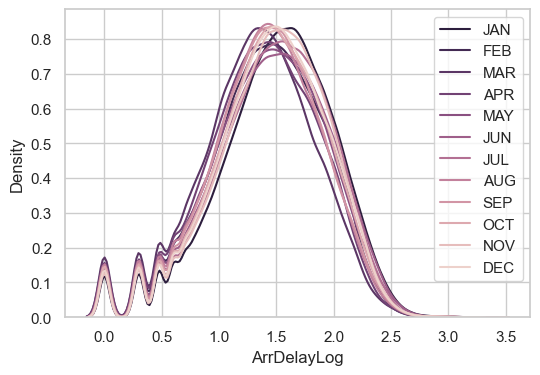

In [256]:
# this one's pretty...pretty useless
sns.kdeplot(x = "ArrDelayLog", hue = "Month", data = df, common_norm = False)
plt.legend(labels = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"])
plt.show()

In [257]:
# lets predict if a flight will arrive late using carrier, destination, and date info
(df["ArrDelay"] <= 0).sum()

np.int64(204956)

In [258]:
df.shape

(1928371, 28)

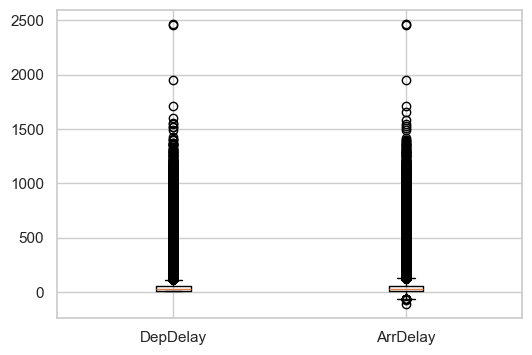

Number of outliers: 41989


In [259]:
# Checking for outliers
plt.boxplot([df['DepDelay'], df['ArrDelay']])
plt.xticks([1, 2], ['DepDelay', 'ArrDelay'])
plt.show()

z_scores = zscore(df[['DepDelay', 'ArrDelay']])
outliers = (abs(z_scores) > 3).any(axis=1)
print("Number of outliers:", outliers.sum())

This plot shows us that there are too many outliers for the mean of the data to provide us with anything useful.

In [260]:
df_num = df[['ArrDelay', 'DepDelay']]
numeric_vars = df_num.columns.values

zscore1 = lambda s: zscore(s, nan_policy='omit')

df_scaled = df_num.apply(zscore1)

In [261]:
df_scaled.apply(['min', 'max']).round(2).transpose()

,min,max
ArrDelay,-2.66,42.60
DepDelay,-0.70,45.51


The calculation of the min and max in this instance shows us that some delay values are negative and may indicate either flights that arrived early, or some sort of error.

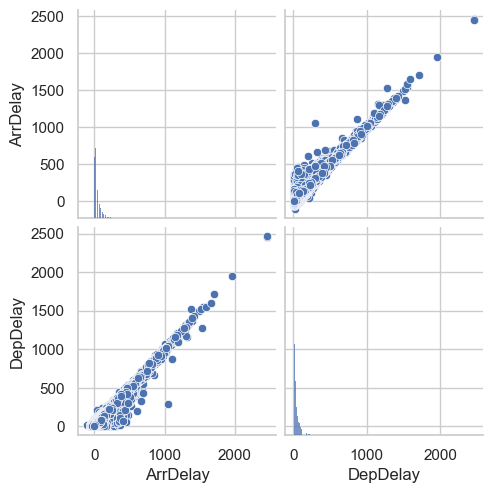

In [262]:
sns.pairplot(df_num);

We can see a strong linear relationship between the departure and arrival delays, making these predictor variables useful.

### Machine Learning

In [263]:
X = df[['DepDelay', 'ArrDelay']]

In [264]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

kmeans = KMeans(n_clusters=3,random_state=0)
cluster_nums = kmeans.fit_predict(X)

Sanity check: Are the clusters too skewed?

In [265]:
cluster_nums[:100]

print("Cluster 1:", np.bincount(cluster_nums)[0])
print("Cluster 2:", np.bincount(cluster_nums)[1]) 
print("Cluster 3:", np.bincount(cluster_nums)[2])

Cluster 1: 1474297
Cluster 2: 64658
Cluster 3: 389416


These clusters seem to expose an acceptable level of skewedness.

In [266]:
pd.DataFrame(kmeans.cluster_centers_, columns=['DepDelay', 'ArrDelay'])

,DepDelay,ArrDelay
0,21.733006,18.972141
1,240.322165,246.791874
2,90.982363,95.932867


Lets visualize our clusters.

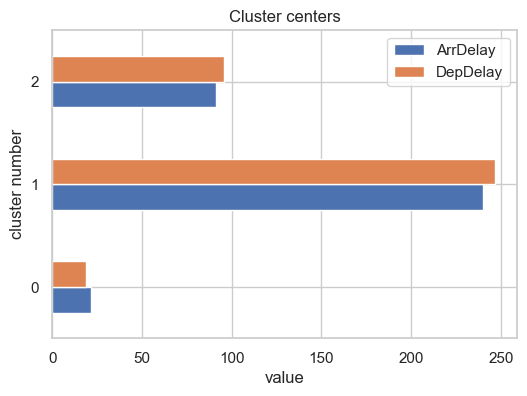

In [267]:
centers = pd.DataFrame(kmeans.cluster_centers_,
columns=['ArrDelay', 'DepDelay'])

centers.plot.barh()
plt.title('Cluster centers')
plt.xlabel('value'); plt.ylabel('cluster number')
plt.show()

This barplot clearly shows how each clusters are grouped, with cluster 1 being the worst and cluster 0 being the best.

In [268]:
airport_stats = df.groupby('Origin').agg({
   'Distance': 'mean',
   'CarrierDelay': 'mean'
}).dropna()

X_scaled = scaler.fit_transform(airport_stats)

In [269]:
kmeans = KMeans(n_clusters=3, random_state=0)
airport_stats['Cluster'] = kmeans.fit_predict(X_scaled)

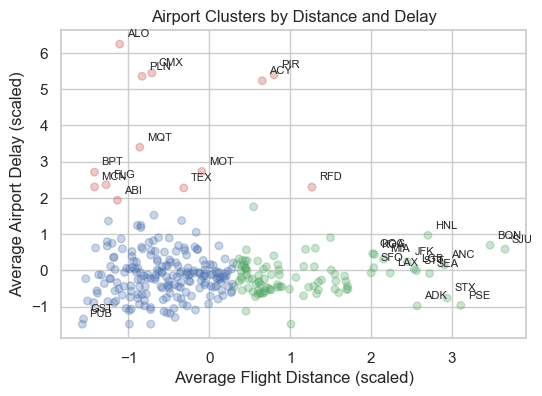

In [270]:
# Blue is decent, red is bad and blue is good airport
colors = ['b', 'r', 'g']

plt.scatter(X_scaled[:, 0], X_scaled[:, 1],
           c=[colors[i] for i in airport_stats['Cluster']],
           s=30, alpha=0.3)

distances = np.sqrt(X_scaled[:, 0]**2 + X_scaled[:, 1]**2)
outlier_threshold = np.percentile(distances, 90)  # Top 10% is outlier threshold
outliers = distances > outlier_threshold

for i, txt in enumerate(airport_stats.index):
    if outliers[i]:
        plt.annotate(txt, (X_scaled[i, 0], X_scaled[i, 1]), 
                    fontsize=8, xytext=(5, 5),
                    textcoords='offset points')

plt.xlabel('Average Flight Distance (scaled)')
plt.ylabel('Average Airport Delay (scaled)')
plt.title('Airport Clusters by Distance and Delay')
plt.show();

We've plotted clusters by distance and delay. The green cluster are the best, the red cluster are the worst, and the blue cluster represents airports with mixed performance.

We can see airports like LAX, SFO and HNL are in the green cluster, meaning they have exceptional performance (low delay given high distance flights).

Airports like ALO, PLN and GMX perform the worst, with the highest delay times despite shorter average flight distances.

We use this plot to gain a general understanding of how the airports in this dataset perform.  

### Delay prediction

Next, let's see if we can *predict* whether a flight is going to be delayed ahead of time using a KNN classifier. If we're right about what factors to use, we should be.

First, though, we have a problem - even though KNN is a relatively fast algorithm, our dataset is so large that prediction becomes prohibitively slow. So, let's randomly sample a more reasonable number of data.

In [271]:
df_reduced = df.sample(n=100000, random_state=0) # TODO: sample count
print(f'Using {df_reduced.shape[0]} rows, reduced from {df.shape[0]}')

Using 100000 rows, reduced from 1928371


Next, let's pick out some variables to use. We know we want to find out if a flight is going to be delayed, so anything with a clear relationship to that is probably going to be useful.

In [272]:
encoder = LabelEncoder()

X = df_reduced[['UniqueCarrier', 'Dest', 'Month', 'DayOfWeek']].copy()

# encode categorical variables
X['Dest'] = encoder.fit_transform(X['Dest'])
X['UniqueCarrier'] = encoder.fit_transform(X['UniqueCarrier'])

Finally, we will perform a train/test split. If we use a `test_size` of 0.1, we should still have plenty of data left for training.

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, df_reduced['IsDelayed'], test_size=0.1, random_state=0)

Now our data is ready, we should be able to train our KNN classifier now. This should be very fast.

In [274]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Perfect, now let's see what happens when we make a prediction off our test data. How's does our classifier perform?

In [275]:
y_pred = knn.predict(X_test)
print(f'Accuracy: {np.mean(y_pred == y_test):.2f}')
print(f'Baseline accuracy: {(np.mean(y_test == True)):.2f}')

Accuracy: 0.87
Baseline accuracy: 0.90


Precision: 0.90
Recall: 0.96
F1 Score: 0.93


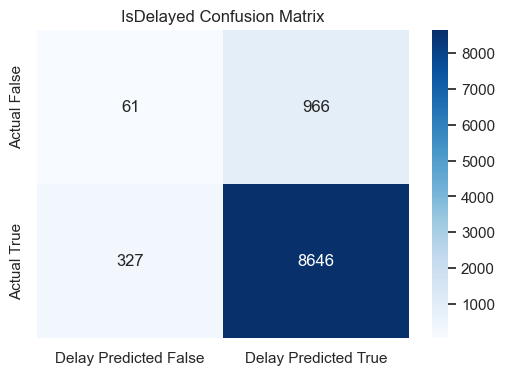

In [276]:
# Output some useful metrics
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_pred, average='binary'):.2f}')


mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Delay Predicted False', 'Delay Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.title('IsDelayed Confusion Matrix')
plt.show()